## NeRF: Neural Radience Field

## Введение
В этом ноутбуке мы будем разбираться как устроена модель [NeRF](https://arxiv.org/abs/2003.08934), предназначенная дле генерации новых ракурсов объекта, а также его объемного представления. <br>
![image.png](./pictures/Drums.png)

Идеей, лежащей в основе модели NeRF, является оптмизация сети, которая на вход получает изображение объекта $RGB \in {R^{H \times W}}$, координаты расположения камеры в момент съемки объекта $x, y, z \in R$ и угол направления камеры $\theta, \phi \in R$ в сферических координатах.
На выходе же модель генерирует лучи, опущенные из координат камеры и проходящие сквозь объект. Луч мы представляем в виде набора точек лежащих по навравлению камеры. Количество точек на луче являтся гиперпараметров модели. Для каждой из точек модель предсказывается какой цвет $RGB$, а также какая плотность объекта $\sigma$ <br>
![image-2.png](./pictures/Model.png)


Код модели был адаптирован из курса [ШАД](https://github.com/yandexdataschool/deep_vision_and_graphics/blob/fall21/week12-nerf/Seminar12_simple_nerf_tutorial.ipynb)

In [ ]:
!mkdir -p data
!cd data
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
!unzip nerf_example_data.zip
!cd ..
!wget https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py
!mv nerf-helper.py nerf_helper.py

In [3]:
! pip install pytorch-lightning
! pip install opencv-python
! pip install imageio

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import json
import os
import pickle

import cv2
import imageio
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
import pytorch_lightning as pl

from nerf_helper import *

### Volume Rendering
Как было сказано во введнии, выходом модели является луч опущенный из координат камеры по направлению к объекту. Важно отметить, что мы опускаем далеко не один луч, а много лучей. Если быть точнее, то мы опускаем луч в каждый пиксель изображения. В каждой точке луча $r(t) = o + t*d$ модель предсказывает цвет и плотность объекта. Для того, чтобы получить итоговый цвет изображения с выбранного ракурса необходимо взять интеграл по всем sample точкам луча. <br>
$C(\mathbf{r})=\int_{t_{n}}^{t_{f}} T(t) \sigma({r}(t)) {c}({r}(t), {d}) d t$,
где $T(t)=\exp \left(-\int_{t_{n}}^{t} \sigma({r}(s)) d s\right)$.

В данной формуле мы суммируем произведения плотности на цвет, тем самым пытаемся оценить интесивность цвета. Множитель $T(t)$ неформально оценивает в какой момент мы встречаем объект, который "загораживает" все последующие sample точки луча. Например, если луч проходит сквозь стекло, то мы можем ожидать, что мы продолжим суммирование далее, так как плотность стекла довольно низкая. Но, если на пути луча попадется, например, любой непрозрачный объект, то на этом путь луча закончится.

В модели мы избегаем работы с интегралом и переводит задачу в дискретное пространство, где мы берем точки по направлению луча в диапозоне от $t_{near}$ и $t_{far}$ равномерно, но с небольшим сдвигом. Техника называется  stratified sampling
![image.png](./pictures/Sampling.png) <br>
И вместо интеграла мы берем дискретную сумму <br>
![image-2.png](./pictures/CoarseLong.png)

In [25]:
class VolumeRenderer(nn.Module):
    def __init__(
        self,
        train_radiance_field_noise_std=0.0,
        val_radiance_field_noise_std=0.0,
        white_background=False,
        attenuation_threshold=1e-3,
        device='cuda'
    ):
        super(VolumeRenderer, self).__init__()
        self.train_radiance_field_noise_std = train_radiance_field_noise_std
        self.val_radiance_field_noise_std = val_radiance_field_noise_std
        self.attenuation_threshold = attenuation_threshold
        self.use_white_bkg = white_background
        epsilon = torch.tensor([1e10]).to(device)
        epsilon.requires_grad = False
        self.register_buffer("epsilon", epsilon)

    def forward(self, radiance_field, depth_values, ray_directions):
        """
        Perform volume rendering by computing the output of NeRF model ('radiance_field')
        Inputs:
            radiance_field: (torch.tensor): (ray_count, num_samples, 4) rgb and sigma
            depth_values:  (torch.tensor): (ray_count, num_samples) : Depths of the sampled positions along the ray
            ray_directions: (torch.tensor): (ray_count, num_samples, 3)
        Outputs:
            rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
        """

        if self.training:
            radiance_field_noise_std = self.train_radiance_field_noise_std
        else:
            radiance_field_noise_std = self.val_radiance_field_noise_std

        # distance between adjacent samples points.
        deltas = torch.cat(
            (
                depth_values[..., 1:] - depth_values[..., :-1],
                self.epsilon.expand(depth_values[..., :1].shape),
            ),
            dim=-1,
        )  # (N_rays, N_samples_)

        # Multiply each distance by the norm (2-norm) of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        # (N_rays, N_samples_)
        deltas = deltas * ray_directions[..., None, :].norm(p=2, dim=-1)

        rgb = radiance_field[..., :3]
        noise = 0.0
        if radiance_field_noise_std > 0.0:
            noise = (
                torch.randn(
                    radiance_field[..., 3].shape,
                    dtype=radiance_field.dtype,
                    device=radiance_field.device
                )
                * radiance_field_noise_std
            )  # (ray_count, num_samples)

        sigmas = torch.nn.functional.softplus(radiance_field[..., 3] + noise)

        # Originally  alphas = 1-torch.exp(-deltas*torch.relu(sigmas+noise))
        alpha = 1.0 - torch.exp(-sigmas * deltas)

        # T_i = cumulative-product(j=1,j=(i-1))(1 - alpha_j)
        # (ray_count, num_samples)
        T_i = cumprod_exclusive(1.0 - alpha + 1e-10)

        # weight_i = T_i * alpha_i
        weights = alpha * T_i  # (ray_count, num_samples)
        # (ray_count, num_samples)
        mask_weights = (T_i > self.attenuation_threshold).float()
        rgb_map = weights[..., None] * rgb  # (ray_count, num_samples, 3)

        # sum over rgb value of each sample points (sum_over R,sum_over G, sum_over B) along the ray
        rgb_map = rgb_map.sum(dim=-2)  # (ray_count, 3)

        # sum over weight of each ray
        acc_map = weights.sum(dim=-1)  # (ray_count, )

        depth_map = (weights * depth_values).sum(dim=-1)  # (ray_count, )

        if self.use_white_bkg:
            rgb_map = rgb_map + (1.0 - acc_map[..., None])

        return rgb_map

### Positional encoding
Важным аспектом качественной работы данного подхода явяляется применение harmonic embeddings, которые повышают размреность входных данных. В [работе](https://arxiv.org/abs/2006.10739) рассказывается как данная техника позволяет увеличить резкость изображения
![image.png](./pictures/PosEnc.png)

$\gamma(x, y, L)=\left[\sin (\pi x), \cos (\pi x), \sin (\pi y), \cos (\pi y), \sin (2 \pi x), \cos (2 \pi x), \sin (2 \pi y), \cos (2 \pi y), \ldots ., \sin \left(2^{L-1} \pi x\right), \cos \left(2^{L-1} \pi x\right), \sin \left(2^{L-1} \pi y\right), \cos \left(2^{L-1} \pi y\right)\right]$





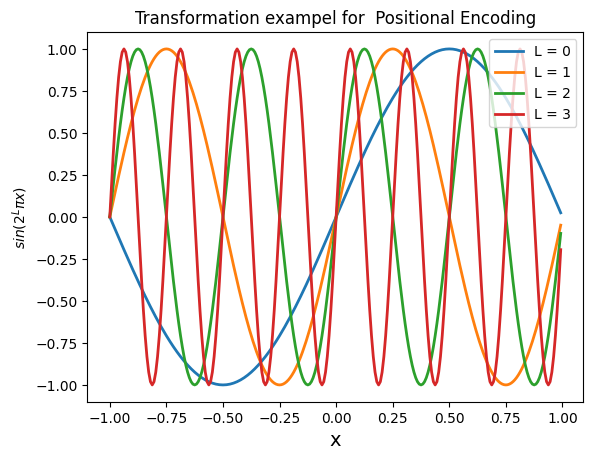

In [26]:
W = 256

x = np.linspace(0, W - 1, W)
x = (x * 1.0 / W) * 2 - 1

L = 4


for el in range(0, L):
    y = np.sin(2 ** el * np.pi * x)
    plt.plot(x, y, label=str('L = {}').format(el), linewidth=2)

plt.title('Transformation exampel for  Positional Encoding')
plt.xlabel('x', fontsize=14)
plt.ylabel(r'$sin(2^L \pi x$)', fontsize=10)
plt.legend(loc='upper right')
plt.show()

In [27]:
class Embedder(nn.Module):
    """
    Defines a function that embeds x to (x, sin(2^k x), cos(2^k x), ...)
    (Different from the paper, prepend input 'x' by default)
    Args:
        input_channels (int): number of input channels
        num_freqs (int): `L_d=4` for viewing direcion, `L_x=10` for 3D-coordinate
        log_scale (bool):
        First take power of 2 for 0 to 9 and then split equally (log_scale=False)
        or choose to generate 0-9 first and then take power of 2 separately
    """

    def __init__(self, input_channels, num_freqs, ):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.input_channels = input_channels
        self.encode_fn = [torch.sin, torch.cos]
        self.output_channels = input_channels * \
            (len(self.encode_fn) * num_freqs + 1)
        self.freq_bands = torch.linspace(1, 2 ** (num_freqs-1), num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (ray_cnt, num_sample, self.in_channels)
        Outputs:
            out: (ray_cnt, num_sample, self.out_channels)
        """
        out = [x]
        for freq in self.freq_bands:
            for func in self.encode_fn:
                out += [func(freq * x)]

        return torch.cat(out, -1)

В данном примере мы попробуем сгенерировать 3D представление модели lego трактора, полученного из игрового движа Unity.

In [28]:
root = 'nerf_synthetic/lego'
main = 'transforms_test.json'

In [29]:
ex_dataset = BlenderDataset('nerf_synthetic/lego/', img_wh=[100, 100])
print(f'Number of pixels: {len(ex_dataset)}')

Number of pixels: 1000000


## Nerf Diagram
Модель, лежащая в основе NeRF является простым MLP. Размерность всех линейных слоев кроме последнего - 256, последний слой имеет размерность 128. В качестве функций активации во всех слоях кроме последнего используется ReLU. В последнем слое используется sigmoid <br>
![image.png](./pictures/NerfArchitecture.png)

Где $\gamma(x)$ - закодированные, с помощью harmonic embeddgins координаты камеры, $\gamma(d)$ - закодированные, с помощью harmonic embeddgins координаты направления, $\sigma$ - предсказанная моделью интенсивность, $RGB$ - предсказанный цвет.
В качестве функции потерь модель Nerf использет MSE <br>

Важным аспектом работы модели NeRF является то, что подход оптимизирует **две сети**. Одну coarse - грубый вывод модели. Вторую fine - отредактированную, на основе техники hierarchical volume sampling. Подход основан на выводе coarse модели и полученных весов для каждой sample точки. Второй проход более аккуратно выбирает sample точки из за чего качество генерации получается лучше.

После замены множителя мы получаем такую формулу для coarse модели, описанную в секции volume rendering <br>
![image-3.png](./pictures/CoarseModel.png)

На основе полученных весов $\hat{w} = w_i / \sum_{j=1}^{N_c} w_j $ мы можем вывести piece wise probability density function. Далее из полученного распределения мы можем брать на лучах точки, которые захватывают интересующий нас объект. И повторным получением цвета по данным точками мы оценим $\hat{C_f}(r)$ <br>
![image.png](./pictures/NerfPipeline.png)

Итоговая функция потерь будет иметь вид <br>
![image-2.png](./pictures/LossFunction.png)

Пример, который будет рассматриваться в данном ноутбуке будет оптимизировать просто coarse часть, без fine <br>

В качестве оптимизатора будет использовать Adam. LR = 5e-4

In [30]:
class NeRF(nn.Module):
    def __init__(self,
                 D=8, W=256,
                 in_channels_xyz=63, in_channels_dir=27,
                 skips=[4]):
        """
        D: number of layers for density (sigma) encoder
        W: number of hidden units in each layer
        in_channels_xyz: number of input channels for xyz (3+3*10*2=63 by default)
        in_channels_dir: number of input channels for direction (3+3*4*2=27 by default)
        skips: add skip connection in the Dth layer
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(D):
            if i == 0:
                layer = nn.Linear(self.in_channels_xyz,  W)
            elif i in skips:
                layer = nn.Linear(self.in_channels_xyz + W,  W)
            else:
                layer = nn.Linear(W,  W)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(W, W)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
            nn.Linear(self.in_channels_dir + W,  W//2),
            nn.ReLU(True),
        )

        # output layers
        self.sigma = nn.Linear(W, 1)
        self.rgb = nn.Sequential(nn.Linear(W//2, 3),
                                 nn.Sigmoid())

    def forward(self, x, sigma_only=False):
        """
        Encodes input (xyz+dir) to rgb+sigma (not ready to render yet).
        For rendering this ray, please see Renderer.py
        Inputs:
            x: (B, self.in_channels_xyz(+self.in_channels_dir))
               the embedded vector of position and direction
            sigma_only: whether to infer sigma only. If True,
                        x is of shape (B, self.in_channels_xyz)
        Outputs:
            if sigma_only:
                sigma: (B, 1) sigma
            else:
                out: (B, 4), rgb and sigma
        """
        if not sigma_only:
            input_xyz, input_dir = \
                torch.split(x, [self.in_channels_xyz, self.in_channels_dir], dim=-1)
        else:
            input_xyz = x

        xyz_ = input_xyz
        for i in range(self.D):
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        sigma = self.sigma(xyz_)
        if sigma_only:
            return sigma

        xyz_encoding_final = self.xyz_encoding_final(xyz_)

        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)
        out = torch.cat([rgb, sigma], dim=-1)
        return out

In [72]:
class NeRFSystem(pl.LightningModule):
    def __init__(self, hparams):
        super(NeRFSystem, self).__init__()
        self.params = hparams

        self.num_workers = 0
        self.loss = nn.MSELoss(reduction='mean')

        self.embedder_xyz = Embedder(
            input_channels=3,
            num_freqs=10,
        )
        # Question: How many input coord will we have?
        self.embedder_dir = Embedder(
            input_channels=3,
            num_freqs=4,
        )
        self.sampler = RaySampleInterval(hparams['N_samples'],
                                         device=self.device)
        self.embeddings = {'xyz': self.embedder_xyz,
                           'dir': self.embedder_dir,
                           }

        self.models = NeRF(in_channels_xyz=hparams['in_feat'])
        self.img_wh = hparams['img_wh']
        # rendering module
        self.volume_renderer = \
            VolumeRenderer(
                train_radiance_field_noise_std=hparams['noise_std'],
                val_radiance_field_noise_std=0,
                white_background=hparams['white_back'],
                attenuation_threshold=1e-5,
                device=self.device
            )

    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def forward(self, ray_batch):
        """ Does a prediction for a batch of rays.
        Args:
            x: Tensor of camera rays containing position, direction and bounds.
        Returns: Tensor with the calculated pixel value for each ray.
        """
        def inference(model, embedder_xyz, xyz, embedder_dir, expanded_rays_dir, device):
            """
            Helper function that performs model inference.
            Inputs:
                model: NeRF model (coarse or fine)
                embedder_xyz: embedding module for xyz
                xyz: (N_rays, N_samples_, 3) sampled positions
                    N_samples_ is the number of sampled points in each ray;
                                = N_samples for coarse model
                                = N_samples+N_importance for fine model
                embedder_dir: embedding module for direction
                expanded_rays_dir: (N_rays, N_samples, 3) :expanded ray directions
            Outputs:
                if sigma_only:
                    radience_field:(N_rays, N_samples, 1)
                else:
                    radience_field:(N_rays, N_samples, 3+1)
            """
            assert xyz.shape[0] == expanded_rays_dir.shape[0], 'Number of ray differ in coordinate and directions!'
            N_rays = xyz.shape[0]
            assert xyz.shape[1] == expanded_rays_dir.shape[1], 'Number of samples differ in coordinate and directions!'
            N_samples = xyz.shape[1]
            # Flatten the first two dimensions -> (N_rays * N_samples, 3)
            xyz_ = xyz.view(-1, 3)  # (N_rays*N_samples_, 3)
            expanded_rays_dir = expanded_rays_dir.contiguous()
            # (N_rays*N_samples_, 3)
            expanded_rays_dir_ = expanded_rays_dir.view(-1, 3)

            xyz_embedded = embedder_xyz(xyz_)  # (N_rays*N_samples_, 63)
            # (N_rays*N_samples_, 27)
            dir_embedded = embedder_dir(expanded_rays_dir_)

            xyzdir_embedded = torch.cat(
                (xyz_embedded, dir_embedded), dim=-1).to(device)
            radiance_field = model(xyzdir_embedded)
            radiance_field = torch.reshape(
                radiance_field, (N_rays, N_samples, -1)).to(device)
            return radiance_field

        # both (N_rays, N_sample, 3)
        ray_origins, ray_directions = ray_batch[:, 0:3], ray_batch[:, 3:6]
        # both (N_rays, N_sample, 1)
        near, far = ray_batch[:, 6:7], ray_batch[:, 7:8]

        # Generating depth samples
        ray_count = ray_directions.shape[0]
        ray_depth_values = self.sampler(
            ray_count=ray_count,
            near=near,
            far=far,
            lindisp=self.params['lindisp'],
            perturb=self.params['perturb']
        )
        # Samples across each ray (N_rays, N_sample, 3)
        ray_points = intervals_to_ray_points(
            ray_depth_values, ray_directions, ray_origins)

        # Expand rays to match batch size
        expanded_ray_directions = ray_directions[..., None, :].expand_as(
            ray_points)
        # Coarse inference
        coarse_radiance_field = inference(
            model=self.models,
            embedder_xyz=self.embedder_xyz,
            embedder_dir=self.embedder_dir,
            xyz=ray_points,
            expanded_rays_dir=expanded_ray_directions,
            device=self.device
        )
        coarse_rgb = self.volume_renderer(coarse_radiance_field,
                                          ray_depth_values,
                                          ray_directions,
                                          )  # volume rendering

        return coarse_rgb

    def setup(self, stage):
        kwargs = {'root_dir': self.params['root_dir'],
                  'img_wh': tuple(self.img_wh)}

        self.train_dataset = BlenderDataset(split='train', **kwargs)
        self.val_dataset = BlenderDataset(split='val', **kwargs)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(get_parameters(self.models),
                                          lr=5e-3,
                                          betas=(0.9, 0.999))
        return [self.optimizer]

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          shuffle=True,
                          num_workers=self.num_workers,
                          batch_size=self.params['batch_size'],
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          shuffle=False,
                          num_workers=self.num_workers,
                          # validate one image (H*W rays) at a time
                          batch_size=1,
                          pin_memory=True)

    def training_step(self, batch, batch_nb):
        rays, rgbs = batch['rays'], batch['rgbs']

        results = self.forward(rays)
        loss = self.loss(results, rgbs)

        with torch.no_grad():
            psnr_coarse = psnr(self.loss(results, rgbs))

        self.log('train/loss', loss)
        self.log('train/psnr_coarse', psnr_coarse, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_nb):
        rays, rgbs = batch['rays'], batch['rgbs']
        rays = rays.squeeze()  # (H*W, 3)
        rgbs = rgbs.squeeze()  # (H*W, 3)
        results = self.forward(rays)
        self.log('val_loss', self.loss(results, rgbs))

        if batch_nb == 0:
            W, H = self.img_wh
            plt.subplot(121)
            plt.imshow(results.view(H, W, 3).cpu().numpy())
            plt.axis('off')
            plt.subplot(122)
            plt.imshow(rgbs.view(H, W, 3).cpu().numpy())
            plt.axis('off')
            plt.show()

        psnr_ = psnr(self.loss(results, rgbs))
        self.log('val_psnr',  psnr_)


In [73]:
args = {
    'batch_size': 2400,
    'noise_std': 0,
    'white_back': True,
    'lindisp': False,
    'perturb': True,
    'in_feat': 63,
    'img_wh': [150, 150],
    'root_dir': 'nerf_synthetic/lego/',
    'N_samples': 64,

}

In [74]:
system = NeRFSystem(args)

In [81]:
epochs = 1
ckpt_path = None

# Initialize the trainer with updated arguments
trainer = pl.Trainer(
    max_epochs=epochs,
    devices=1,
    accelerator="gpu",
    num_sanity_val_steps=1,
    check_val_every_n_epoch=1,
    benchmark=True,
    profiler="simple"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params | Mode
-------------------------------------------------------------
0 | loss            | MSELoss           | 0      | eval
1 | embedder_xyz    | Embedder          | 0      | eval
2 | embedder_dir    | Embedder          | 0      | eval
3 | sampler         | RaySampleInterval | 0      | eval
4 | models          | NeRF              | 595 K  | eval
5 | volume_renderer | VolumeRenderer    | 0      | eval
-------------------------------------------------------------
595 K     Trainable params
0         Non-trainable params
595 K     Total params
2.383     Total estimated model params size (MB)
0         Modules in train mode
38        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

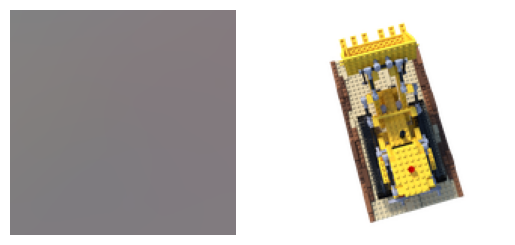

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

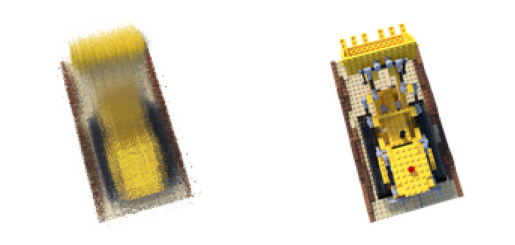

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                              

In [82]:
trainer.fit(system, ckpt_path=ckpt_path)

In [ ]:
torch.save(system.models.state_dict(), 'model.pt')

In [83]:
from IPython.display import HTML
from base64 import b64encode
import imageio
def show_vid(frames, path='video.mp4'):
    imageio.mimwrite(path, frames, fps=30, quality=7)
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
    """ % data_url)

In [84]:
def trans_t(t):
    t = torch.as_tensor(t)
    return torch.tensor([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,t],
        [0,0,0,1]], dtype=torch.float)

def rot_phi(phi):
    phi = torch.as_tensor(phi)
    return torch.tensor([
        [1,0,0,0],
        [0,torch.cos(phi),-torch.sin(phi),0],
        [0,torch.sin(phi), torch.cos(phi),0],
        [0,0,0,1]], dtype=torch.float)

def rot_theta(theta):
    theta = torch.as_tensor(theta)
    return torch.tensor([
        [torch.cos(theta),0,-torch.sin(theta),0],
        [0,1,0,0],
        [torch.sin(theta),0, torch.cos(theta),0],
        [0,0,0,1]], dtype=torch.float)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w


In [85]:

N_SAMPLES = 32
H = W = 150
frames = []
system = system.cuda()
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)

    rays_o, rays_d = get_rays_with_dir(system.train_dataset.dir_cam, c2w[:3, :4])

    near = 2.0
    far = 6.0
    rays = torch.cat([rays_o, rays_d,
                              near*torch.ones_like(rays_o[:, :1]),
                              far*torch.ones_like(rays_o[:, :1])],
                              1) # (H*W, 8)

    with torch.no_grad():
        rgb = system(rays.cuda())
        # rgb = render_rays(model, rays_o.cuda(), rays_d.cuda(), near=2., far=6., n_samples=N_SAMPLES)
    # frames.append(())
    frames.append((255*np.clip(rgb.view(H, W, 3).cpu().numpy(), 0, 1)).astype(np.uint8))



<ipython-input-85-a51b7b68a095>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [86]:
show_vid(frames)

In [ ]:
del frames

## Вывод
В данном ноутбуке нам удалось разобраться с особенностями работы NeRF

Из-за того, что что лучи опускаются в каждый пиксель, могут возникнуть артифакты генерации. К тому же опускать луч в каждый пиксель довольно ресурсо затратно. Поэтому, исследователи в области моделей Nerf предложили решение, которое рассматривает сцену как нечто непрерывное и вместо использования лучей в каждый пиксель проводит конусы (canonical frustrums). Это позволяет достигнуть меньшего количества артифактов генерации, к тому же ускоряет работу модели. [Ссылка](https://arxiv.org/abs/2103.13415) <br>
![image.png](./pictures/MipNerf.png)